In [64]:
from reconstruct import * 
from projection_import import * 
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from PIL import Image
import imageio
from scipy.ndimage import median_filter, uniform_filter
import re

In [66]:
# Specify the path to the HDF5 file
file_path = r"C:\Users\gdhakal\Documents\Git\Automatic_COR_finder\C200\10_230110_1538_C200_____Z90_Y6460_50000eV_10x_300ms\10_230110_1538_00001.h5"

# Specify the folder to save and load the TIFF files
tiff_folder = r"C:\Users\gdhakal\Documents\Git\Automatic_COR_finder\Experiment Notebooks\C200_10\small_tiff"

# Create an instance of ProjectionFile
FileObject = ProjectionFile(file_path)

# Open the HDF5 file and retrieve the volume and metadata
volume_path = "/entry/data/data"
metadata_paths = ['/entry/instrument/NDAttributes/CT_MICOS_W']

volume, metadata = FileObject.openFile(volume=volume_path, metadata=metadata_paths)

volume opened successfully : data shape:  (1890, 2160, 2560)


### Reconstructing One Slice with Multiple Looped COR

In [67]:
#Assigning reco_setting values
reco_setting = {
    'angle_list_dir': '/entry/instrument/NDAttributes/CT_MICOS_W',
    'number_of_FFs': 20,
    'slice_number': 1000,
    'DarkFieldValue': 200,
    'backIlluminationValue': 0,
    'offset_Angle': 0,
    'angle_range': '180 - axis centered',
    'extend_FOV_fixed_ImageJ_Stream': 0.25,
    'reco_algorithm': 'gridrec',
    'filter_name': 'shepp',
    'pixel_size': 0.72,
    'ring_radius': 50
    }

In [ ]:
# Specify the values
n = 10
e_values = [ 1, 2, 3, 4]

# Specify the first COR value (c)
c = 1222

cor_values = []
# Loop through the values
for e in e_values:
    for i in range(-n * e, n * e + 1, e):
        cor_value = c + i
        cor_values.append(cor_value)

        # Instantiate the Reconstruction object
        recoObject = Reconstruction(FileObject, gpu=True)
        # Set the COR value in the reconstruction settings
        reco_setting["COR"] = cor_value

        # Generate the Slice using the reco_settings
        slice = recoObject.on_the_fly_one_slice(reco_setting)

        # Specify the intensity range
        min_intensity = -20
        max_intensity = 100

        # Clip the image intensities within the desired range
        clipped_image = np.clip(slice, min_intensity, max_intensity)

        # Scale the intensities to the range [0, 255]
        scaled_image = ((clipped_image - min_intensity) / (max_intensity - min_intensity) * 255).astype(np.uint8)

        str_cor_value = str(cor_value).replace ('.' , 'p' )

        # Save the reconstructed slice
        save_file_name = f"reconstructed_e{e}_n{n}_cor{str_cor_value}.tif"
        # np.save(save_file_name, slice)

        # Save the scaled image as a TIFF file
        imageio.imwrite(os.path.join(tiff_folder, save_file_name), scaled_image)

        print("Reconstructed slice saved successfully as", save_file_name)    


In [73]:
# Function to read and give COR, e, and n of a file
def parse_reconstructed_filename(filename):
    # Extract COR, e, and n values from the filename using regular expressions
    match = re.search(r"reconstructed_e(\d+)_n(\d+)_cor(\d+p\d+)\.tif|reconstructed_e(\d+)_n(\d+)_cor(\d+)\.tif", filename)
    
    if match:
        if match.group(3):
            e1 = int(match.group(1))
            n1 = int(match.group(2))
            cor = float(match.group(3).replace("p", "."))
        else:
            e1 = int(match.group(4))
            n1 = int(match.group(5))
            cor = float(match.group(6))
        
        return cor, e1, n1
    
    return None

# Initialize arrays to store COR, e, and n values
cor_file = []
e_file = []
n_file = []
path = []
fname = []

# Iterate over the TIFF files in the directory
for filename in os.listdir(tiff_folder):
    if filename.endswith(".tif"):
        # Get the full file path
        filepath = os.path.join(tiff_folder, filename)
        
        # Parse the COR, e, and n values from the filename
        result = parse_reconstructed_filename(filename)
        
        if result:
            cor, e1, n1 = result
            # Append the values to the respective arrays
            cor_file.append(cor)
            e_file.append(e1)
            n_file.append(n1)
            path.append(filepath)
            fname.append(filename)

# Print the arrays
df_new = pd.DataFrame({"path": path, "filename": fname, "COR": cor_file, "e": e_file, "n": n_file})

print(df_new)

                                                 path  \
0   C:\Users\gdhakal\Documents\Git\Automatic_COR_f...   
1   C:\Users\gdhakal\Documents\Git\Automatic_COR_f...   
2   C:\Users\gdhakal\Documents\Git\Automatic_COR_f...   
3   C:\Users\gdhakal\Documents\Git\Automatic_COR_f...   
4   C:\Users\gdhakal\Documents\Git\Automatic_COR_f...   
..                                                ...   
79  C:\Users\gdhakal\Documents\Git\Automatic_COR_f...   
80  C:\Users\gdhakal\Documents\Git\Automatic_COR_f...   
81  C:\Users\gdhakal\Documents\Git\Automatic_COR_f...   
82  C:\Users\gdhakal\Documents\Git\Automatic_COR_f...   
83  C:\Users\gdhakal\Documents\Git\Automatic_COR_f...   

                            filename     COR  e   n  
0   reconstructed_e1_n10_cor1212.tif  1212.0  1  10  
1   reconstructed_e1_n10_cor1213.tif  1213.0  1  10  
2   reconstructed_e1_n10_cor1214.tif  1214.0  1  10  
3   reconstructed_e1_n10_cor1215.tif  1215.0  1  10  
4   reconstructed_e1_n10_cor1216.tif  1216.0 

### Finding Standard Deviation for Smaller Section and Plotting It


In [74]:
# Function to calculate standard deviation
def new_calculate_std(path):
    image = Image.open(path)  # Read the image based on the filename
    image_array = np.array(image)
    std = np.std(image_array)
    return std

# Apply the function to calculate standard deviation for each file
df_new['std_dev'] = df_new['path'].apply(new_calculate_std)

# Print the updated DataFrame
#print(df_description)

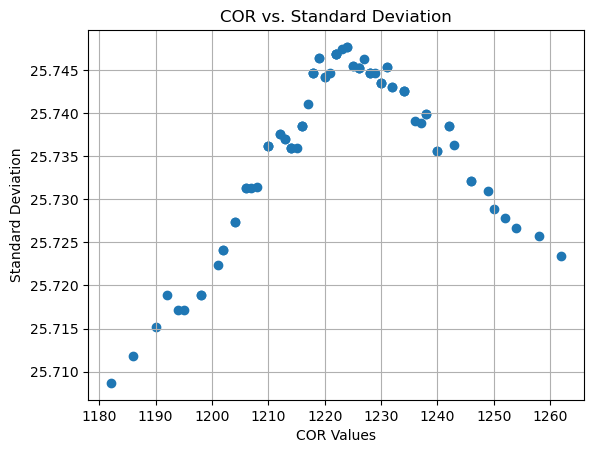

In [75]:
plt.scatter(df_new["COR"],df_new["std_dev"])
plt.xlabel('COR Values')
plt.ylabel('Standard Deviation')
plt.title('COR vs. Standard Deviation')
plt.grid(True)
plt.show()

In [76]:
# Find the file with the maximum standard deviation
max_std_dev_row = df_new.loc[df_new["std_dev"].idxmax()]

# Access the filename and maximum standard deviation value
largest_file = max_std_dev_row["filename"]
largest_std_dev = max_std_dev_row["std_dev"]

print("File with Maximum Standard Deviation:", largest_file, "With Deviation:", largest_std_dev)

File with Maximum Standard Deviation: reconstructed_e1_n10_cor1224.tif With Deviation: 25.747706339334233


##### Mean Filter

In [ ]:
# # Function to calculate mean filtered standard deviation
# def new_calculate_mean_std(path):
#     image = Image.open(path)  # Read the image based on the filename

#     # Apply mean filter
#     mean_filtered = uniform_filter(image, size=3) 

#     mean_image_array = np.array(mean_filtered)
#     mean_std = np.std(mean_image_array)
#     return mean_std

# # Apply the function to calculate standard deviation for each file
# df_new['mean_std_dev'] = df_new['path'].apply(new_calculate_mean_std)

# # Print the updated DataFrame
# #print(df_description)

In [ ]:
# plt.scatter(df_new["COR"],df_new["mean_std_dev"])
# plt.xlabel('COR Values')
# plt.ylabel('Standard Deviation')
# plt.title('COR vs. Mean Filtered Standard Deviation')
# plt.grid(True)
# plt.show()

In [ ]:
# # Find the file with the maximum standard deviation
# max_std_dev_mean = df_new.loc[df_new["mean_std_dev"].idxmax()]

# # Access the filename and maximum standard deviation value
# m_largest_file = max_std_dev_mean["filename"]
# m_largest_std_dev = max_std_dev_mean["mean_std_dev"]

# print("File with Maximum Standard Deviation (Mean Filter):", m_largest_file, "With Deviation:", m_largest_std_dev)

##### Median Filter

In [ ]:
# # Function to calculate standard deviation
# def calculate_median_std(path):
#     image = Image.open(path)  # Read the image based on the filename

#     # Apply median filter
#     median_filtered = median_filter(image, size=3)

#     image_array = np.array(median_filtered)
#     median_std = np.std(image_array)
#     return median_std

# # Apply the function to calculate standard deviation for each file
# df_new['median_std_dev'] = df_new['path'].apply(calculate_median_std)

# # Print the updated DataFrame
# #print(df_description)

In [ ]:
# plt.scatter(df_new["COR"],df_new["median_std_dev"])
# plt.xlabel('COR Values')
# plt.ylabel('Standard Deviation')
# plt.title('COR vs. Median Filtered Standard Deviation')
# plt.grid(True)
# plt.show()

In [ ]:
# # Find the file with the maximum standard deviation
# max_std_dev_median = df_new.loc[df_new["median_std_dev"].idxmax()]

# # Access the filename and maximum standard deviation value
# me_largest_file = max_std_dev_median["filename"]
# me_largest_std_dev = max_std_dev_median["median_std_dev"]

# print("File with Maximum Standard Deviation (Median Filter):", me_largest_file, "With Deviation:", me_largest_std_dev)